## Pre-processing and Visualization

In [1]:
# Include the required libraries.
import random
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults

random.seed(21)

In [2]:
# Read the CSV file data.
data = pd.read_csv('TimeSeries.csv')
data['Water'] = pd.to_numeric(data['Water'])
evaluation_index = 69

In [3]:
data

,Year,Water
0,1885,356
1,1886,386
2,1887,397
3,1888,397
4,1889,413
...,...,...
74,1959,594
75,1960,587
76,1961,587
77,1962,625


In [4]:
# Function for generating the walk-forward validation set.
def walk_forward_validation(unsplit_data, base_window_size):
    X = []
    Y = []

    while base_window_size < unsplit_data.shape[0]:
        validation_sequence = unsplit_data.iloc[: base_window_size, 1].tolist()
        validation_test = unsplit_data.iloc[base_window_size, 1]
        X.append(validation_sequence)
        Y.append(validation_test)
        base_window_size += 1

    return X, Y

In [5]:
# Generate the walk-forward training and testing sets.
X, Y = walk_forward_validation(data, 5)

XTrain = X[:-10]
YTrain = Y[:-10]
XTest = X[-10:]
YTest = Y[-10:]

## Naive Forecast / Persistence

In [6]:
# Function for generating naive forecasts.
def naive_forecast(X):
    forecast = []
    
    for x in X:
        forecast.append(x[-1])
    
    return forecast

In [7]:
# Print the RMSE for Naive Forecasting.
print('Naive Forecast Evaluation')

YTrainPred = naive_forecast(XTrain)
print('Training RMSE: ', mean_squared_error(YTrain, YTrainPred, squared = False))

YTestPred = naive_forecast(XTest)
print('Testing RMSE: ', mean_squared_error(YTest, YTestPred, squared = False))

Naive Forecast Evaluation
Training RMSE:  35.40855299217973
Testing RMSE:  17.190113437671084


## Summary Statistics and Plots

### Summary Statistics

In [8]:
# Print the summary statistics.
print(data.iloc[: evaluation_index, 1].describe())

count     69.000000
mean     500.478261
std       73.901685
min      344.000000
25%      458.000000
50%      492.000000
75%      538.000000
max      662.000000
Name: Water, dtype: float64


### Line Plot

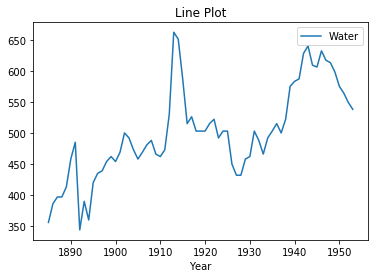

In [9]:
# Plot the line plot for training set.
data.iloc[: evaluation_index, :].plot.line(x = 'Year', y = 'Water', title = 'Line Plot')

### Density Plot

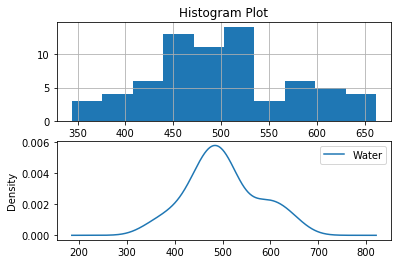

In [10]:
# Plot the density plot for training set.
plt.figure(1)
plt.subplot(211)
plt.title('Histogram Plot')
data.iloc[: evaluation_index, 1].hist()
plt.subplot(212)
data.iloc[: evaluation_index, 1].plot(kind = 'kde', legend = 'Water')
plt.show()

### Box-and-Whisker Plot

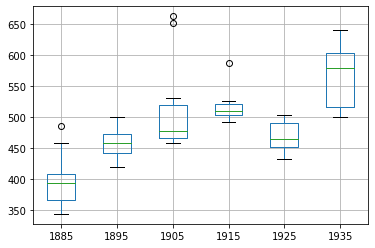

In [11]:
# Plot the box-and-whisker plot for training set.
series = pd.read_csv('TimeSeries.csv', index_col = 'Year', parse_dates = True)
groups = series['1885' : '1944'].groupby(pd.Grouper(freq = '10AS'))
decades = pd.DataFrame()

for name, group in groups:
    decades[name.year] = group.values.ravel()

decades.boxplot()
plt.show()

## ARIMA Modelling

In [12]:
# Function for evaluating the dataset on an ARIMA configuration.
def evaluate_arima_model(train, test, arima_order):
    history = [x[0] for x in train]
    predictions = []

    for t in range(len(test)):
        model = ARIMA(history, order = arima_order)
        try:
            model_fit = model.fit(trend = 'nc', disp = 0, transparams = False)
        except:
            model_fit = model.fit(trend = 'nc', disp = 0, start_params = [1, .1, .1])
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    mse = mean_squared_error(test, predictions, squared = False)
    return mse, predictions

In [13]:
# Function for grid-searching the best ARIMA configuration.
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg, best_predictions = float("inf"), None, None
    train, test = dataset[0 : evaluation_index], dataset[evaluation_index : ]

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                
                try:
                    mse, predictions = evaluate_arima_model(train, test, order)
                    
                    if mse < best_score:
                        best_score, best_cfg, best_predictions = mse, order, predictions
                except:
                    continue
                
                print('ARIMA Configuration: %s RMSE = %.3f' % (order,mse))
    
    print('\nBest ARIMA Configuration: %s RMSE = %.3f' % (best_cfg, best_score))
    return (test, best_predictions)

Initiating Grid Search
ARIMA Configuration: (1, 2, 1) RMSE = 16.432
ARIMA Configuration: (1, 2, 2) RMSE = 14.340
ARIMA Configuration: (2, 2, 1) RMSE = 15.951

Best ARIMA Configuration: (1, 2, 2) RMSE = 14.340


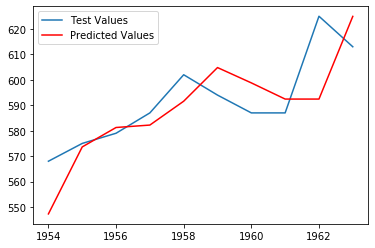

In [14]:
# Routine for generating the best ARIMA model plots.
x = data.iloc[evaluation_index :, 0].values
series = pd.read_csv('TimeSeries.csv', index_col = 'Year', parse_dates = True)
p_values = range(1, 3)
d_values = range(1, 3)
q_values = range(1, 3)
warnings.filterwarnings("ignore")

print('Initiating Grid Search')
test, predictions = evaluate_models(series.values, p_values, d_values, q_values)
plt.plot(x, test, label = 'Test Values')
plt.plot(x, predictions, color = 'red', label = 'Predicted Values')
plt.legend()
plt.show()